Coronavirus disease 2019 (COVID-19) is an infectious disease caused by the virus strain "severe acute respiratory syndrome coronavirus 2" (SARS-CoV-2). The disease was first identified in 2019 in Wuhan, China, and has since spread globally, resulting in the 2019–20 coronavirus pandemic.
https://en.wikipedia.org/wiki/Coronavirus_disease_2019

In [113]:
#Libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
from datetime import date, timedelta
from sklearn.cluster import KMeans
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import plotly.offline as py
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import math
import datetime
import os

In [114]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/coronavirusdataset/TimeAge.csv
/kaggle/input/coronavirusdataset/Region.csv
/kaggle/input/coronavirusdataset/Time.csv
/kaggle/input/coronavirusdataset/Weather.csv
/kaggle/input/coronavirusdataset/SearchTrend.csv
/kaggle/input/coronavirusdataset/TimeProvince.csv
/kaggle/input/coronavirusdataset/TimeGender.csv
/kaggle/input/coronavirusdataset/PatientInfo.csv
/kaggle/input/coronavirusdataset/PatientRoute.csv
/kaggle/input/coronavirusdataset/SeoulFloating.csv
/kaggle/input/coronavirusdataset/Case.csv


1-Patient Info

In [115]:
path = '/kaggle/input/coronavirusdataset/'
patient_data_path = path + 'PatientInfo.csv'
df_patient = pd.read_csv(patient_data_path)

In [49]:
df_patient.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [50]:
#df_patient.isna().sum()

In [51]:
df_patient['birth_year'] = df_patient.birth_year.fillna(0.0).astype(int)
df_patient['birth_year'] = df_patient['birth_year'].map(lambda val: val if val > 0 else np.nan)

In [52]:
df_patient.confirmed_date = pd.to_datetime(df_patient.confirmed_date)
daily_count = df_patient.groupby(df_patient.confirmed_date).patient_id.count()
accumulated_count = daily_count.cumsum()

In [53]:
#accumulated_count

In [54]:
df_patient['age'] = 2020 - df_patient['birth_year'] 

In [55]:

def group_age(age):
    if age >= 0: # not NaN
        if age % 10 != 0:
            lower = int(math.floor(age / 10.0)) * 10
            upper = int(math.ceil(age / 10.0)) * 10 - 1
            return f"{lower}-{upper}"
        else:
            lower = int(age)
            upper = int(age + 9) 
            return f"{lower}-{upper}"
    return "Unknown"


df_patient["age_range"] = df_patient["age"].apply(group_age)
#print(df_patient["age_range"])

In [56]:
df_patient.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,age_range
0,1000000001,2.0,male,1964.0,56.0,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,50-59
1,1000000002,5.0,male,1987.0,33.0,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released,30-39
2,1000000003,6.0,male,1964.0,56.0,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,50-59
3,1000000004,7.0,male,1991.0,29.0,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,20-29
4,1000000005,9.0,female,1992.0,28.0,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,20-29


In [57]:
patient=df_patient

In [58]:
date_cols = ["confirmed_date", "released_date", "deceased_date"]
for col in date_cols:
    patient[col] = pd.to_datetime(patient[col])

In [116]:
patient["time_to_release_since_confirmed"] = patient["released_date"] - patient["confirmed_date"]
patient["time_to_death_since_confirmed"] = patient["deceased_date"] - patient["confirmed_date"]
patient["duration_since_confirmed"] = patient[["time_to_release_since_confirmed", "time_to_death_since_confirmed"]].min(axis=1)
patient["duration_days"] = patient["duration_since_confirmed"].dt.days
age_ranges = sorted(set([ar for ar in patient["age_range"] if ar != "Unknown"]))
patient["state_by_gender"] = patient["state"] + "_" + patient["sex"]

In [60]:
datetime.date.today()

datetime.date(2020, 3, 20)

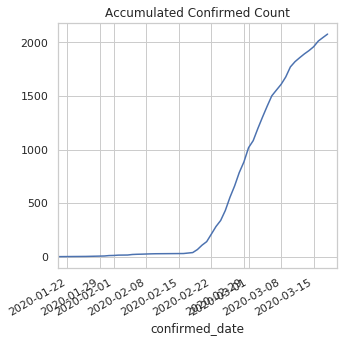

In [61]:
fig, ax = plt.subplots()
accumulated_count.plot()
fig.autofmt_xdate()
ax.set_xlim([datetime.date(2020, 1, 20), datetime.date.today()]) #add today
plt.title('Accumulated Confirmed Count');

In [62]:
infected_patient = patient.shape[0]
rp = patient.loc[patient["state"] == "released"].shape[0]
dp = patient.loc[patient["state"] == "deceased"].shape[0]
ip = patient.loc[patient["state"]== "isolated"].shape[0]
rp=rp/patient.shape[0]
dp=dp/patient.shape[0]
ip=ip/patient.shape[0]
print("The percentage of recovery is "+ str(rp*100) )
print("The percentage of deceased is "+ str(dp*100) )
print("The percentage of isolated is "+ str(ip*100) )


The percentage of recovery is 13.841298467087466
The percentage of deceased is 1.4427412082957618
The percentage of isolated is 80.74842200180342


In [63]:
states = pd.DataFrame(patient["state"].value_counts())
states["status"] = states.index
states.rename(columns={"state": "count"}, inplace=True)

fig = px.pie(states,
             values="count",
             names="status",
             title="Current state of patients",
             template="seaborn")
fig.update_traces(rotation=90, pull=0.05, textinfo="value+percent+label")
fig.show()

In [64]:
released = df_patient[df_patient.state == 'released']
released.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,...,confirmed_date,released_date,deceased_date,state,age_range,time_to_release_since_confirmed,time_to_death_since_confirmed,duration_since_confirmed,duration_days,state_by_gender
0,1000000001,2.0,male,1964.0,56.0,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,...,2020-01-23,2020-02-05,NaT,released,50-59,13 days,NaT,13 days,13.0,released_male
1,1000000002,5.0,male,1987.0,33.0,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,...,2020-01-30,2020-03-02,NaT,released,30-39,32 days,NaT,32 days,32.0,released_male
2,1000000003,6.0,male,1964.0,56.0,Korea,Seoul,Jongno-gu,NaN,contact with patient,...,2020-01-30,2020-02-19,NaT,released,50-59,20 days,NaT,20 days,20.0,released_male
3,1000000004,7.0,male,1991.0,29.0,Korea,Seoul,Mapo-gu,NaN,overseas inflow,...,2020-01-30,2020-02-15,NaT,released,20-29,16 days,NaT,16 days,16.0,released_male
4,1000000005,9.0,female,1992.0,28.0,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,...,2020-01-31,2020-02-24,NaT,released,20-29,24 days,NaT,24 days,24.0,released_female


In [65]:
isolated_state = df_patient[df_patient.state == 'isolated']
isolated_state.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,...,confirmed_date,released_date,deceased_date,state,age_range,time_to_release_since_confirmed,time_to_death_since_confirmed,duration_since_confirmed,duration_days,state_by_gender
14,1000000015,40.0,male,1943.0,77.0,Korea,Seoul,Seongdong-gu,NaN,Seongdong-gu APT,...,2020-02-19,NaT,NaT,isolated,70-79,NaT,NaT,NaT,NaN,isolated_male
17,1000000018,111.0,male,2000.0,20.0,Korea,Seoul,etc,NaN,etc,...,2020-02-20,NaT,NaT,isolated,20-29,NaT,NaT,NaT,NaN,isolated_male
19,1000000020,121.0,female,1944.0,76.0,Korea,Seoul,Seongdong-gu,NaN,Seongdong-gu APT,...,2020-02-20,NaT,NaT,isolated,70-79,NaT,NaT,NaT,NaN,isolated_female
21,1000000022,161.0,male,1985.0,35.0,Korea,Seoul,Seodaemun-gu,NaN,Eunpyeong St. Mary's Hospital,...,2020-02-21,NaT,NaT,isolated,30-39,NaT,NaT,NaT,NaN,isolated_male
22,1000000023,188.0,male,1961.0,59.0,Korea,Seoul,Seocho-gu,NaN,Shincheonji Church,...,2020-02-21,NaT,NaT,isolated,50-59,NaT,NaT,NaT,NaN,isolated_male


In [66]:
dead = df_patient[df_patient.state == 'deceased']
dead.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,...,confirmed_date,released_date,deceased_date,state,age_range,time_to_release_since_confirmed,time_to_death_since_confirmed,duration_since_confirmed,duration_days,state_by_gender
388,1200000038,38.0,female,1963.0,57.0,Korea,Daegu,Nam-gu,True,NaN,...,2020-02-18,NaT,2020-02-23,deceased,50-59,NaT,5 days,5 days,5.0,deceased_female
427,1200000114,114.0,male,1946.0,74.0,Korea,Daegu,NaN,NaN,Shincheonji Church,...,2020-02-21,NaT,2020-02-26,deceased,70-79,NaT,5 days,5 days,5.0,deceased_male
428,1200000620,620.0,male,1949.0,71.0,Korea,Daegu,NaN,NaN,NaN,...,2020-02-24,NaT,2020-03-02,deceased,70-79,NaT,7 days,7 days,7.0,deceased_male
429,1200000901,901.0,female,1934.0,86.0,Korea,Daegu,NaN,NaN,NaN,...,2020-02-25,NaT,2020-03-04,deceased,80-89,NaT,8 days,8 days,8.0,deceased_female
430,1200001064,1064.0,female,1943.0,77.0,Korea,Daegu,NaN,NaN,NaN,...,2020-02-26,NaT,2020-03-01,deceased,70-79,NaT,4 days,4 days,4.0,deceased_female


**Age distribution of the released**

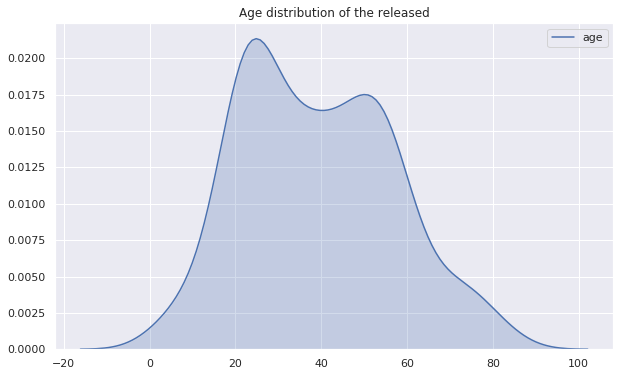

In [67]:
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of the released")
sns.kdeplot(data=released['age'], shade=True)

**Age distribution of isolated person**

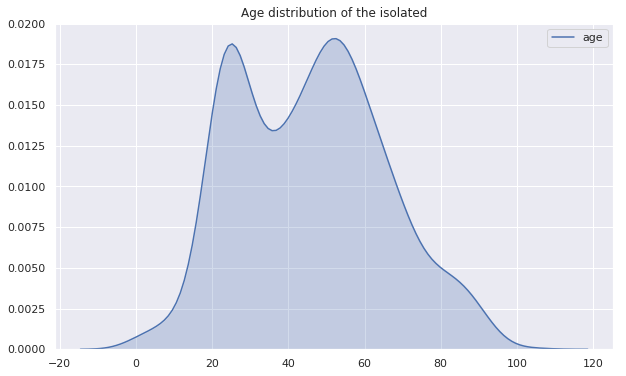

In [68]:
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of the isolated")
sns.kdeplot(data=isolated_state['age'], shade=True)

**Age distribution of death**

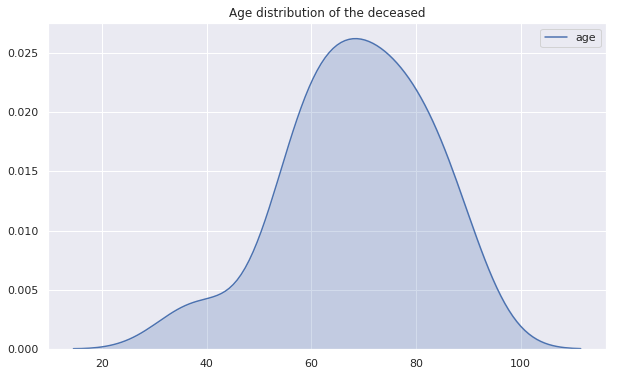

In [69]:
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of the deceased")
sns.kdeplot(data=dead['age'], shade=True)

In [70]:
male_dead = dead[dead.sex=='male']
female_dead = dead[dead.sex=='female']

**Age distribution of death by gender**

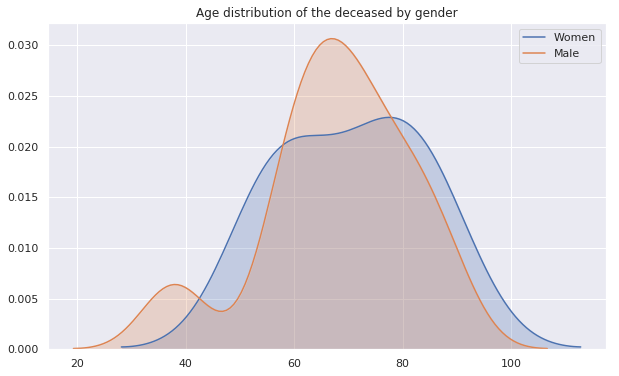

In [71]:
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of the deceased by gender")
sns.kdeplot(data=female_dead['age'], label="Women", shade=True)
sns.kdeplot(data=male_dead['age'],label="Male" ,shade=True)

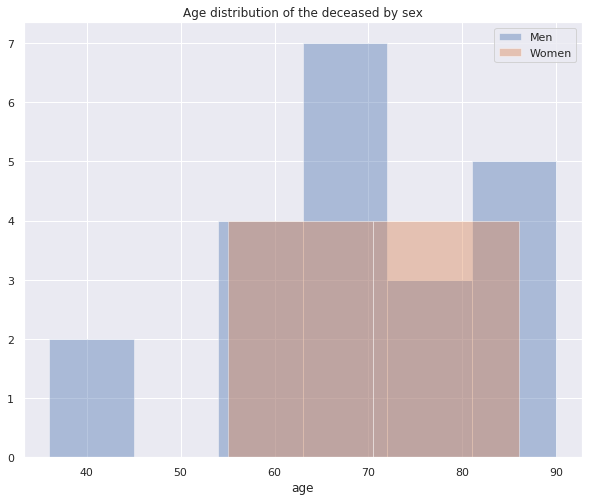

In [72]:
plt.figure(figsize=(10,8))
sns.set_style("darkgrid")
sns.distplot(a=male_dead['age'], label="Men", kde=False)
sns.distplot(a=female_dead['age'], label="Women", kde=False)
plt.title("Age distribution of the deceased by sex")
plt.legend()

**Comparison of released and deceased by age**

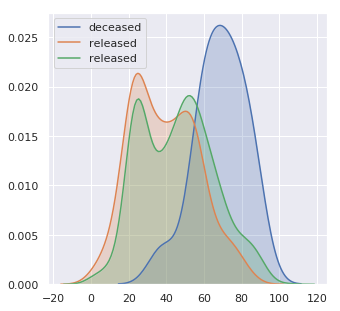

In [73]:
sns.kdeplot(data=dead['age'],label='deceased', shade=True)
sns.kdeplot(data=released['age'],label='released', shade=True)
sns.kdeplot(data=isolated_state['age'],label='released', shade=True)

**Death by gender**

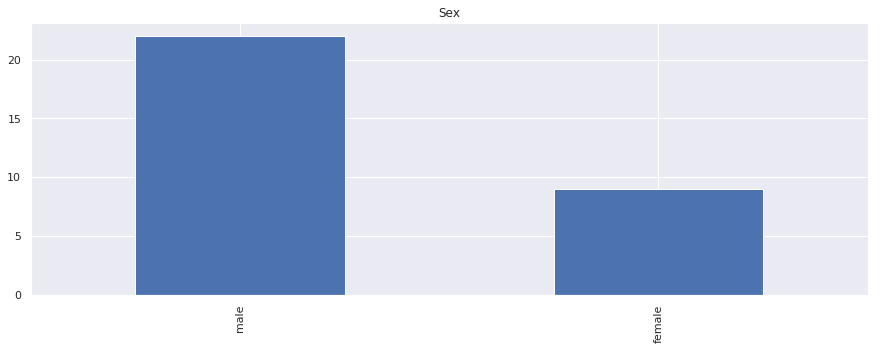

In [74]:
plt.figure(figsize=(15, 5))
plt.title('Sex')
dead.sex.value_counts().plot.bar();

**Reason for the infection**

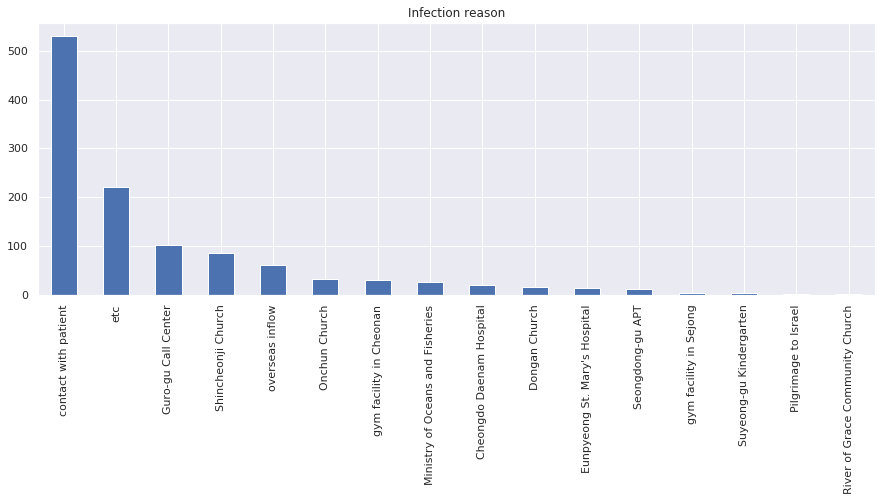

In [75]:
plt.figure(figsize=(15,5))
plt.title('Infection reason')
df_patient.infection_case.value_counts().plot.bar();

In [76]:
fig = px.pie( values=df_patient.groupby(['infection_case']).size().values,names=df_patient.groupby(['infection_case']).size().index)
fig.update_layout(
    font=dict(
        size=15,
        color="#242323"
    )
    )   
    
py.iplot(fig)

**State of Patient**

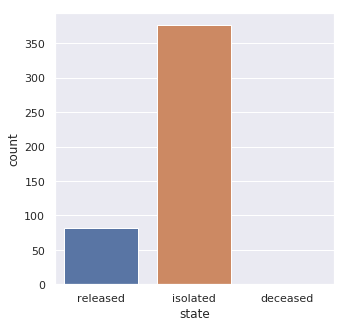

In [77]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x=df_patient['state'].loc[
    (df_patient['infection_case']=='contact with patient')
])

**State of male patient**

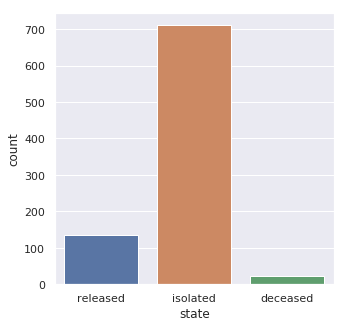

In [78]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x=df_patient['state'].loc[(df_patient['sex']=="male")])

**State of female patient**

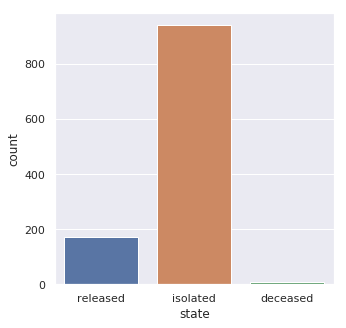

In [79]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x=df_patient['state'].loc[(df_patient['sex']=="female")])

**State of patient(male and female) vs age **

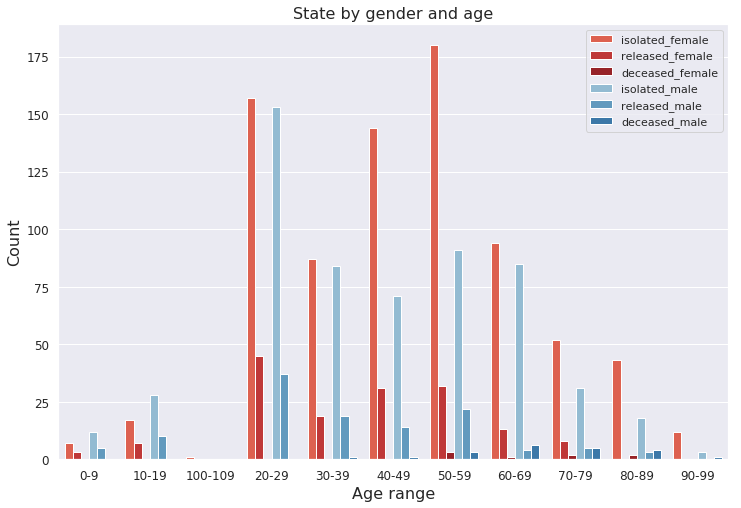

In [80]:
age_gender_hue_order =["isolated_female", "released_female", "deceased_female",
                       "isolated_male", "released_male", "deceased_male"]
custom_palette = sns.color_palette("Reds")[3:6] + sns.color_palette("Blues")[2:5]

plt.figure(figsize=(12, 8))
sns.countplot(x = "age_range",
              hue="state_by_gender",
              order=age_ranges,
              hue_order=age_gender_hue_order,
              palette=custom_palette,
              data=patient)
plt.title("State by gender and age", fontsize=16)
plt.xlabel("Age range", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="upper right")
plt.show()

**Region by age and state**

2- route data

In [117]:
route_data_path = path + 'PatientRoute.csv'
df_route = pd.read_csv(route_data_path)
df_route.head()

,patient_id,global_num,date,province,city,latitude,longitude
0,1400000001,1,2020-01-19,Incheon,Jung-gu,37.460459,126.440680
1,1400000001,1,2020-01-20,Incheon,Seo-gu,37.478832,126.668558
2,1000000001,2,2020-01-22,Gyeonggi-do,Gimpo-si,37.562143,126.801884
3,1000000001,2,2020-01-23,Seoul,Jung-gu,37.567454,127.005627
4,2000000001,3,2020-01-20,Incheon,Jung-gu,37.460459,126.440680


In [82]:
clus=df_route.loc[:,['id','latitude','longitude']]
clus.head(10)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



,id,latitude,longitude
0,NaN,37.460459,126.440680
1,NaN,37.478832,126.668558
2,NaN,37.562143,126.801884
3,NaN,37.567454,127.005627
4,NaN,37.460459,126.440680
5,NaN,37.524978,127.027718
6,NaN,37.503359,127.049177
7,NaN,37.524669,127.015911
8,NaN,37.529200,127.032597
9,NaN,37.674192,126.776955


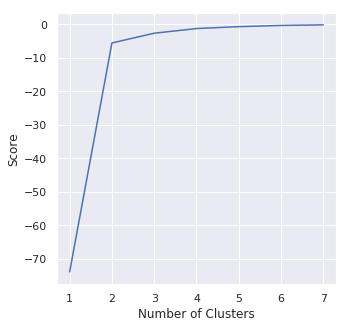

In [83]:
K_clusters = range(1,8)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df_route[['latitude']]
X_axis = df_route[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

In [84]:
kmeans = KMeans(n_clusters = 4, init ='k-means++')
kmeans.fit(clus[clus.columns[1:3]])
clus['cluster_label'] = kmeans.fit_predict(clus[clus.columns[1:3]])
centers = kmeans.cluster_centers_
labels = kmeans.predict(clus[clus.columns[1:3]])

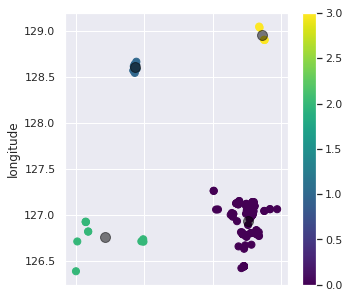

In [85]:
clus.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)

In [86]:
import folium
worldmap = folium.Map(location=[32.4279,53.6880 ], zoom_start=4,tiles='Stamen Toner')
   
for lat, lon,city in zip(df_route['latitude'], df_route['longitude'],df_route['city']):
    folium.CircleMarker([lat, lon],
                        radius=5,
                        color='red',
                      popup =('City: ' + str(city) + '<br>'),
                        fill_color='red',
                        fill_opacity=0.7 ).add_to(worldmap)
worldmap

In [118]:
import folium
southkorea_map = folium.Map(location=[36.55,126.983333 ], zoom_start=7,tiles='Stamen Toner')

for lat, lon,city in zip(df_route['latitude'], df_route['longitude'],df_route['city']):
    folium.CircleMarker([lat, lon],
                        radius=5,
                        color='red',
                      popup =('City: ' + str(city) + '<br>'),
                        fill_color='red',
                        fill_opacity=0.7 ).add_to(southkorea_map)
southkorea_map

**Prediction**

In [88]:
data = daily_count.resample('D').first().fillna(0).cumsum()
data = data[20:]
x = np.arange(len(data)).reshape(-1, 1)
y = data.values

**Regression Model**

In [89]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=[32, 32, 10], max_iter=50000, alpha=0.0005, random_state=26)
_=model.fit(x, y)

In [90]:
test = np.arange(len(data)+7).reshape(-1, 1)
pred = model.predict(test)
prediction = pred.round().astype(int)
week = [data.index[0] + timedelta(days=i) for i in range(len(prediction))]
dt_idx = pd.DatetimeIndex(week)
predicted_count = pd.Series(prediction, dt_idx)

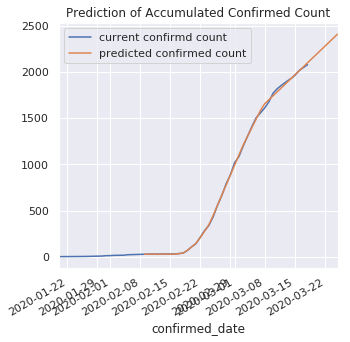

In [91]:
accumulated_count.plot()
predicted_count.plot()
plt.title('Prediction of Accumulated Confirmed Count')
plt.legend(['current confirmd count', 'predicted confirmed count'])
plt.show()

**Prophet**

In [92]:
prophet= pd.DataFrame(data)
prophet
pr_data = prophet.reset_index()
pr_data.columns = ['ds','y']
pr_data.head()

,ds,y
0,2020-02-09,27.0
1,2020-02-10,28.0
2,2020-02-11,28.0
3,2020-02-12,28.0
4,2020-02-13,28.0


In [93]:
m=Prophet()
m.fit(pr_data)
future=m.make_future_dataframe(periods=365)
forecast=m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-02-09,-139.400754,-254.799168,5.999369,-139.400754,-139.400754,15.337235,15.337235,15.337235,15.337235,15.337235,15.337235,0.0,0.0,0.0,-124.063519
1,2020-02-10,-106.918000,-239.782788,14.406116,-106.918000,-106.918000,-6.381250,-6.381250,-6.381250,-6.381250,-6.381250,-6.381250,0.0,0.0,0.0,-113.299250
2,2020-02-11,-74.435247,-215.170186,44.501976,-74.435247,-74.435247,-11.911723,-11.911723,-11.911723,-11.911723,-11.911723,-11.911723,0.0,0.0,0.0,-86.346970
3,2020-02-12,-41.952494,-199.578771,70.889968,-41.952494,-41.952494,-18.108612,-18.108612,-18.108612,-18.108612,-18.108612,-18.108612,0.0,0.0,0.0,-60.061106
4,2020-02-13,-9.469740,-130.737670,149.124143,-9.469740,-9.469740,13.971230,13.971230,13.971230,13.971230,13.971230,13.971230,0.0,0.0,0.0,4.501490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,2021-03-14,30242.857429,19910.279839,41542.981208,19903.456360,41525.118443,15.337235,15.337235,15.337235,15.337235,15.337235,15.337235,0.0,0.0,0.0,30258.194664
400,2021-03-15,30320.352205,19925.454035,41677.446814,19905.953377,41607.677441,-6.381250,-6.381250,-6.381250,-6.381250,-6.381250,-6.381250,0.0,0.0,0.0,30313.970955
401,2021-03-16,30397.846981,19865.952287,41764.932424,19910.114957,41737.925479,-11.911723,-11.911723,-11.911723,-11.911723,-11.911723,-11.911723,0.0,0.0,0.0,30385.935258
402,2021-03-17,30475.341758,19936.662999,41848.104445,19914.016927,41857.988995,-18.108612,-18.108612,-18.108612,-18.108612,-18.108612,-18.108612,0.0,0.0,0.0,30457.233145


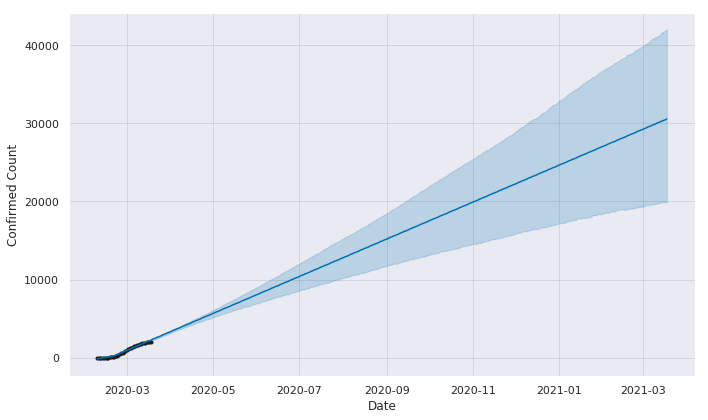

In [94]:
figure = plot_plotly(m, forecast)
py.iplot(figure) 

figure = m.plot(forecast,xlabel='Date',ylabel='Confirmed Count')


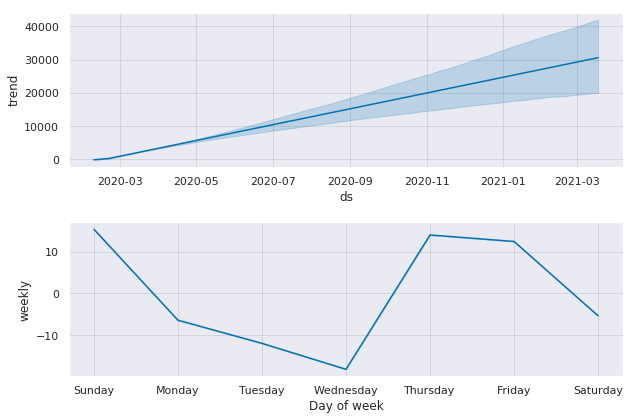

In [95]:
figure=m.plot_components(forecast)


**Autoregressive integrated moving average(Arima)**

In [96]:
confirm_cs = pd.DataFrame(data).cumsum()
arima_data = confirm_cs.reset_index()
arima_data.columns = ['confirmed_date','count']
arima_data.head()

,confirmed_date,count
0,2020-02-09,27.0
1,2020-02-10,55.0
2,2020-02-11,83.0
3,2020-02-12,111.0
4,2020-02-13,139.0


In [97]:
model = ARIMA(arima_data['count'].values, order=(1, 2, 1))
fit_model = model.fit(trend='c', full_output=True, disp=True)
fit_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                   37
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -166.111
Method:                       css-mle   S.D. of innovations             21.151
Date:                Fri, 20 Mar 2020   AIC                            340.222
Time:                        13:16:07   BIC                            346.665
Sample:                             2   HQIC                           342.493
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.8243     27.070      1.471      0.141     -13.232      92.881
ar.L1.D2.y     0.9286      0.060     15.582      0.000       0.812       1.045
ma.L1.D2.y    -0.3155      0.146     -2.160      0.031      -0.602      -0.029
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0769           +0.0000j            1.0769            0.0000
MA.1            3.1692           +0.0000j            3.1692            0.0000
-----------------------------------------------------------------------------
"""

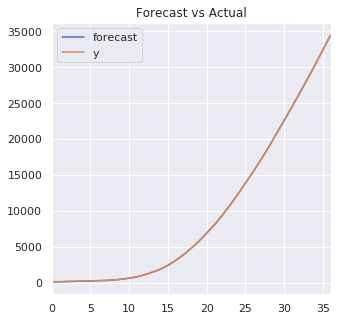

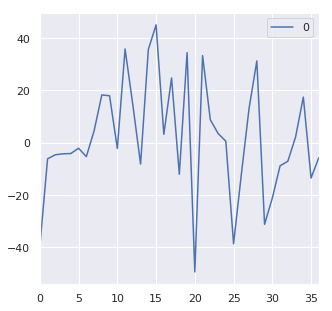

In [98]:
fit_model.plot_predict()
plt.title('Forecast vs Actual')
pd.DataFrame(fit_model.resid).plot()


**Forecasting future Values**

In [99]:
forcast = fit_model.forecast(steps=5)
pred_y = forcast[0].tolist()
pd.DataFrame(pred_y)

,0
0,36565.379244
1,38711.526619
2,40892.803236
3,43109.544416
4,45362.061531


**LSTM**

In [100]:
dataset = pd.DataFrame(data)
dataset.columns = ['Confirmed']
dataset.head()

,Confirmed
confirmed_date,
2020-02-09,27.0
2020-02-10,28.0
2020-02-11,28.0
2020-02-12,28.0
2020-02-13,28.0


In [101]:
data = np.array(dataset).reshape(-1, 1)
train_data = dataset[:len(dataset)-5]
test_data = dataset[len(dataset)-5:]

In [102]:
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)
n_input =5
n_features =1
                             
generator = TimeseriesGenerator(scaled_train_data,scaled_train_data, length=n_input, batch_size=1)

lstm_model = Sequential()
lstm_model.add(LSTM(units = 50, return_sequences = True, input_shape = (n_input, n_features)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units = 50, return_sequences = True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units = 50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units = 1))
lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
lstm_model.fit(generator, epochs = 30)

Epoch 1/30
29/29 [==============================] - 2s 78ms/step - loss: 0.2003
Epoch 2/30
29/29 [==============================] - 0s 12ms/step - loss: 0.0293
Epoch 3/30
29/29 [==============================] - 0s 12ms/step - loss: 0.0216
Epoch 4/30
29/29 [==============================] - 0s 13ms/step - loss: 0.0204
Epoch 5/30
29/29 [==============================] - 0s 11ms/step - loss: 0.0131
Epoch 6/30
29/29 [==============================] - 0s 11ms/step - loss: 0.0138
Epoch 7/30
29/29 [==============================] - 0s 11ms/step - loss: 0.0388
Epoch 8/30
29/29 [==============================] - 0s 11ms/step - loss: 0.0149
Epoch 9/30
29/29 [==============================] - 0s 11ms/step - loss: 0.0161
Epoch 10/30
29/29 [==============================] - 0s 11ms/step - loss: 0.0103
Epoch 11/30
29/29 [==============================] - 0s 11ms/step - loss: 0.0065
Epoch 12/30
29/29 [==============================] - 0s 11ms/step - loss: 0.0095
Epoch 13/30
29/29 [==================

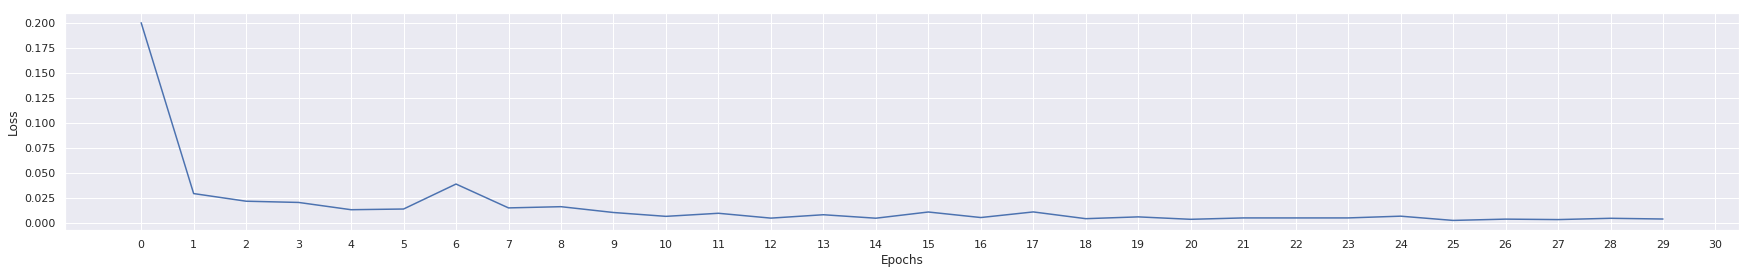

In [103]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize = (30,4))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(0,100,1))
plt.plot(range(len(losses_lstm)), losses_lstm)

In [104]:
lstm_predictions_scaled = []

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [105]:
prediction = pd.DataFrame(scaler.inverse_transform(lstm_predictions_scaled))
prediction.head()

,0
0,1715.550505
1,1737.142519
2,1745.780191
3,1745.649797
4,1735.093680
